# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from time import time
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC

from tqdm import tqdm
import os

D:\Program Files(C)\Anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('D:/Machine Learning Notes/Python Notebook/Amazon Fine Food Reviews Analysis/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:07<00:00, 1291.53it/s]


In [23]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.
# Combining all the above stundents 
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

 37%|███████████████████████████▌                                              | 32724/87773 [00:16<00:28, 1898.26it/s]D:\Program Files(C)\Anaconda\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 70%|███████████████████████████████████████████████████▊                      | 61402/87773 [00:33<00:12, 2137.89it/s]D:\Program Files(C)\Anaconda\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 75%|███████████████████████████████████████████████████████▎                  | 65606/87773 [00:35<00:11, 1973.26it/s]D:\Program Files(C)\Anaconda\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass th

In [25]:
preprocessed_summary[0]

'made china'

## [4.3].  Split Dataset into Train and Test

In [26]:
from sklearn import model_selection as ms
y=final['Score'][:100000]
dw_train,dw_test,y_train,y_test=ms.train_test_split(preprocessed_reviews, y, stratify=y, test_size=0.3, random_state=0)

# [4] Featurization

## [4.1] BAG OF WORDS

In [27]:
#BoW
count_vect = CountVectorizer(dtype='float') #in scikit-learn
d_train =count_vect.fit_transform(dw_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaarrrrrggghhh', 'aaaaah', 'aaah', 'aaahs']


In [28]:
print("the type of count vectorizer ",type(d_train))
print("the shape of train-text BOW vectorizer ",d_train.get_shape())

d_test = count_vect.transform(dw_test)
print("the shape of test-text BOW vectorizer ",d_test.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train-text BOW vectorizer  (61441, 46047)
the shape of test-text BOW vectorizer  (26332, 46047)


## [4.2] Bi-Grams and n-Grams.

In [29]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect_gram = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
d_train_gram = count_vect_gram.fit_transform(dw_train)

In [30]:
#Vectorize cv and test data
print("the type of count vectorizer ",type(d_train_gram))
print("the shape of train-text BOW vectorizer ",d_train_gram.get_shape())

d_test_gram = count_vect_gram.transform(dw_test)
print("the shape of test-text BOW vectorizer ",d_test_gram.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train-text BOW vectorizer  (61441, 5000)
the shape of test-text BOW vectorizer  (26332, 5000)


## [4.3] TF-IDF

In [31]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
d_train_tf =tf_idf_vect.fit_transform(dw_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

some sample features(unique words in the corpus) ['aafco', 'aback', 'abandon', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew', 'able drink']


In [32]:
#Vectorize cv and test data
print("the type of count vectorizer ",type(d_train_tf))
print("the shape of train-text BOW vectorizer ",d_train_tf.get_shape())

d_test_tf = tf_idf_vect.transform(dw_test)
print("the shape of test-text BOW vectorizer ",d_test_tf.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train-text BOW vectorizer  (61441, 36194)
the shape of test-text BOW vectorizer  (26332, 36194)


## [4.4] Word2Vec

In [27]:
# Train your own Word2Vec model using your own text corpus
train_list=[]
test_list=[]
for sent in dw_train:
    train_list.append(sent.split())
for sent in dw_test:
    test_list.append(sent.split())

In [28]:
# Using Google News Word2Vectors
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(train_list,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.822709321975708), ('awesome', 0.817183792591095), ('fantastic', 0.8169326782226562), ('excellent', 0.8103747367858887), ('wonderful', 0.7806501984596252), ('terrific', 0.7770112156867981), ('amazing', 0.7562711238861084), ('perfect', 0.7422863245010376), ('decent', 0.7002018690109253), ('nice', 0.6535245180130005)]
[('greatest', 0.7651511430740356), ('best', 0.7233803272247314), ('tastiest', 0.6810969114303589), ('closest', 0.6696071028709412), ('experienced', 0.6656286716461182), ('softest', 0.6455549001693726), ('disgusting', 0.6202574968338013), ('coolest', 0.6155783534049988), ('awful', 0.6050782203674316), ('smoothest', 0.5930044054985046)]


In [29]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14742
sample words  ['kids', 'love', 'amazon', 'great', 'deal', 'back', 'school', 'sale', 'use', 'snacks', 'go', 'live', 'long', 'commute', 'no', 'matter', 'wonderful', 'complaints', 'flavor', 'gobbled', 'right', 'flavors', 'hit', 'house', 'plus', 'currently', 'made', 'peanut', 'free', 'facility', 'allergic', 'folks', 'four', 'chihuahuas', 'seemed', 'interested', 'treats', 'not', 'seem', 'know', 'quite', 'first', 'licked', 'walked', 'away', 'finally', 'one', 'managed', 'crunch', 'ate']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [60]:
# average Word2Vec
# compute average word2vec for each review in train dataset.
#train dataset
d_train_w2 = [];
for sent in tqdm(train_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    d_train_w2.append(sent_vec)
print(len(d_train_w2))
print(len(d_train_w2[0]))

100%|████████████████████████████████████████████████████████████████████████████| 61441/61441 [15:20<00:00, 48.76it/s]


61441
50


In [61]:
# average Word2Vec
# compute average word2vec for each review in test dataset.
#test dataset
d_test_w2 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(test_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    d_test_w2.append(sent_vec)
print(len(d_test_w2))
print(len(d_test_w2[0]))

100%|████████████████████████████████████████████████████████████████████████████| 26332/26332 [06:04<00:00, 72.23it/s]


26332
50


#### [4.4.1.2] TFIDF weighted W2v

In [30]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(dw_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [31]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

d_train_tf_wt = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(train_list): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    d_train_tf_wt.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 61441/61441 [58:23<00:00, 17.54it/s]


In [32]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

#test dataset
d_test_tf_wt = [];
row=0;
for sent in tqdm(test_list): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    d_test_tf_wt.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 26332/26332 [24:28<00:00, 17.94it/s]


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [33]:
# Please write all the code with proper documentation
def cv_sgd_grid(d_trai, y_trai):
    import warnings
    warnings.filterwarnings('ignore')

    #defining 'alpha' for grid-search alpha = 1/C
    param= {'alpha':[0.0001,0.001,0.01,1,10,100,1000,10000],'penalty':["l1","l2"]}

    #Using Grid Search to get Best alpha=1/c
    start = time()
    #hinge loss for svm
    clfSGD = SGDClassifier(loss='hinge', class_weight='balanced')
    clf = GridSearchCV(clfSGD, param, cv=5,scoring='roc_auc')
    clf.fit(d_trai, y_trai)
    print("Time elapsed : %.2f Seconds" % (time() - start))
    print(" optimal alpha using Grid Search is " + str(clf.best_params_))
    optimal_alpha_grid=clf.best_params_.get('alpha')
    best_penal=clf.best_params_.get('penalty')
    return optimal_alpha_grid,best_penal

In [34]:
def plotROC(d_trai,y_trai,d_tes,y_tes,clf):
    train_score = clf.predict_proba(d_trai)[:,1]
    test_score = clf.predict_proba(d_tes)[:,1]
    fpr_train, tpr_train, _ = roc_curve(y_trai, train_score)
    fpr_test, tpr_test, _ = roc_curve(y_tes, test_score)
    auc_train = auc(fpr_train, tpr_train)
    auc_test = auc(fpr_test, tpr_test)
    plt.title('Receiver Operating Characteristic Curve')
    plt.plot(fpr_train, tpr_train, label = 'AUC Train = %0.2f' % auc_train)
    plt.plot(fpr_test, tpr_test, label = 'AUC Test = %0.2f' % auc_test)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'k--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return auc_train,auc_test

In [35]:
def plotTrainvsTestAUC(d_trai,y_trai,d_tes,y_tes,penalty):
    import warnings
    from math import log
    warnings.filterwarnings('ignore')
    auc_train_list=list()
    auc_test_list=list()
    param=[0.0001,0.001,0.01,1,10,100,1000,10000]
    x=list()
    for i in tqdm(param):
        x.append(log(i,10))
        model=SGDClassifier(loss='hinge',penalty=penalty,alpha=i,class_weight='balanced')
        model.fit(d_trai,y_trai)
        clf=CalibratedClassifierCV(model,method='sigmoid',cv='prefit')
        clf.fit(d_trai,y_trai)
        train_score = clf.predict_proba(d_trai)[:,1]
        test_score = clf.predict_proba(d_tes)[:,1]
        fpr_train, tpr_train, _ = roc_curve(y_trai, train_score)
        fpr_test, tpr_test, _ = roc_curve(y_tes, test_score)
        auc_train_list.append(auc(fpr_train, tpr_train))
        auc_test_list.append(auc(fpr_test, tpr_test))
    plt.title('Train AUC Score vs Test AUC Score')
    plt.plot(x, auc_train_list, label = 'Train AUC Score')
    plt.plot(x, auc_test_list, label = 'Test AUC Score')
    plt.legend(loc = 'lower right')
    plt.xlabel('Log OF Alpha (1/C)')
    plt.ylabel('AUC Score')
    plt.show()

In [36]:
#plot confusion matrix and print report
def report(x,y,model,auc_):
    y_true, y_pred = y, model.predict(x)
    print(classification_report(y_true, y_pred))
    print()
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print("The value of TPR is %.3f" %(tp/(fn+tp)) +
          "\nThe value of TNR is %.3f" %(tn/(tn+fp)) +
         "\nThe value of FPR is %.3f" %(fp/(tn+fp)) +
         "\nThe value of FNR is %.3f" %(fn/(fn+tp)) )
         
    cm=confusion_matrix(y_true, y_pred)
    ax=sns.heatmap(cm,annot=True,fmt="d")
    ax.set(xlabel='Predicted', ylabel='Actual')
    print()    
    print("The auc score is %f" %auc_)

In [45]:
#getting best alpha and best regularizer
alpha_grid,reg_bow = cv_sgd_grid(d_train,y_train)

Time elapsed : 11.88 Seconds
 optimal alpha using Grid Search is {'alpha': 0.001, 'penalty': 'l2'}


In [46]:
#model with best regulariser
model_temp=SGDClassifier(penalty=reg_bow,loss="hinge",alpha=alpha_grid,class_weight='balanced')
model_temp.fit(d_train,y_train)

SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

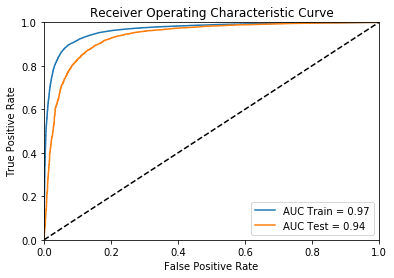

In [47]:
#plot roc curve for train and test data
#creating CalibrationModel on top of SGD
clf_bw=CalibratedClassifierCV(model_temp,method='sigmoid',cv='prefit')
clf_bw.fit(d_train,y_train)
auc_train,auc_test=plotROC(d_train,y_train,d_test,y_test,clf_bw)

100%|██████████| 8/8 [00:02<00:00,  3.32it/s]


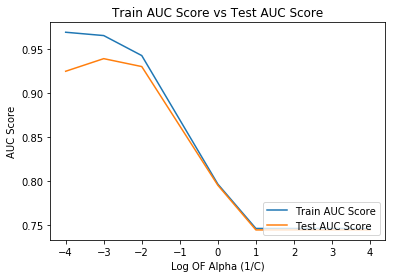

In [81]:
#plotting train vs test auc curve on log of alpha
plotTrainvsTestAUC(d_train,y_train,d_test,y_test,reg_bow)

              precision    recall  f1-score   support

           0       0.71      0.88      0.79      9927
           1       0.98      0.93      0.95     51514

   micro avg       0.92      0.92      0.92     61441
   macro avg       0.84      0.91      0.87     61441
weighted avg       0.93      0.92      0.93     61441


The value of TPR is 0.930
The value of TNR is 0.883
The value of FPR is 0.117
The value of FNR is 0.070

The auc score is 0.965765


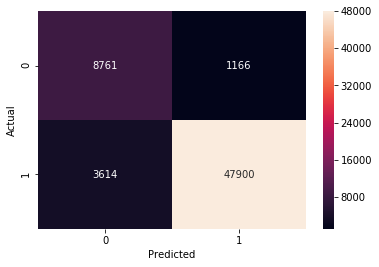

In [49]:
#report on training dataset
report(d_train,y_train,model_temp,auc_train)

              precision    recall  f1-score   support

           0       0.67      0.81      0.73      4254
           1       0.96      0.92      0.94     22078

   micro avg       0.90      0.90      0.90     26332
   macro avg       0.81      0.87      0.84     26332
weighted avg       0.91      0.90      0.91     26332


The value of TPR is 0.922
The value of TNR is 0.810
The value of FPR is 0.190
The value of FNR is 0.078

The auc score is 0.935528


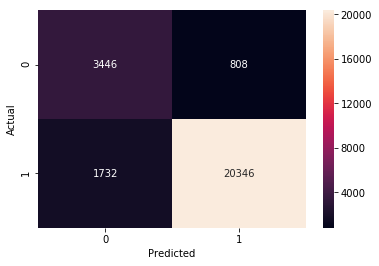

In [50]:
#report on test dataset
report(d_test,y_test,model_temp,auc_test)

In [51]:
##sorting by weights (indices) and getting the last 10 weights
w_=model_temp.coef_
feature_names = count_vect.get_feature_names()
pos = sorted(zip(w_[0], feature_names))
print("Top 10 Positive Words Are::\n",pos[-10:])

Top 10 Positive Words Are::
 [(0.658084273108339, 'smooth'), (0.6605575283886033, 'pleased'), (0.6906634261675605, 'yummy'), (0.7275740495370459, 'awesome'), (0.7504814161632636, 'amazing'), (0.7742139178185786, 'excellent'), (0.781405608676179, 'best'), (0.8079721423203736, 'perfect'), (0.8096622815273081, 'wonderful'), (0.9722924479355334, 'delicious')]


In [52]:
print("Top 10 Negative Words Are::\n",pos[:10])

Top 10 Negative Words Are::
 [(-1.1247112263439034, 'worst'), (-1.058172548669205, 'disappointing'), (-0.9003561910960796, 'disappointed'), (-0.8392041481139514, 'terrible'), (-0.8255614726422811, 'disappointment'), (-0.8084257516056869, 'awful'), (-0.7673916028977397, 'unfortunately'), (-0.718196591231438, 'weak'), (-0.7173448767698518, 'sorry'), (-0.7137345690027811, 'bland')]


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [53]:
# Please write all the code with proper documentation
#getting best alpha and best regularizer
alpha_grid_tf,reg_tf = cv_sgd_grid(d_train_tf,y_train)

Time elapsed : 14.57 Seconds
 optimal alpha using Grid Search is {'alpha': 0.0001, 'penalty': 'l2'}


In [54]:
#model with best regulariser
model_temp_tf=SGDClassifier(penalty=reg_tf,loss="hinge",alpha=alpha_grid_tf,class_weight='balanced')
model_temp_tf.fit(d_train_tf,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

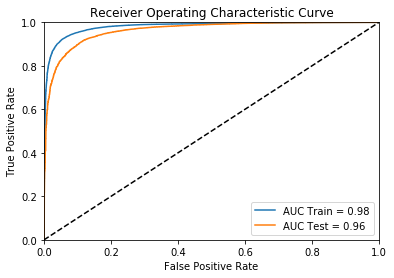

In [55]:
#plot roc curve on train and test data
#creating CalibrationModel on top of SGD
clf_tf=CalibratedClassifierCV(model_temp_tf,method='sigmoid',cv='prefit')
clf_tf.fit(d_train_tf,y_train)
auc_train_tf,auc_test_tf=plotROC(d_train_tf,y_train,d_test_tf,y_test,clf_tf)

100%|██████████| 8/8 [00:03<00:00,  1.91it/s]


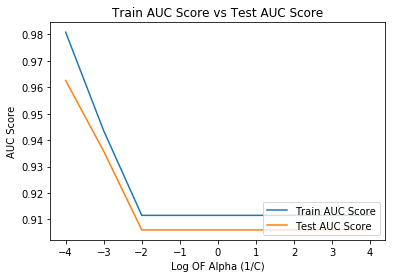

In [82]:
#plotting train vs test auc curve on log of alpha
plotTrainvsTestAUC(d_train_tf,y_train,d_test_tf,y_test,reg_tf)

              precision    recall  f1-score   support

           0       0.69      0.95      0.80      9927
           1       0.99      0.92      0.95     51514

   micro avg       0.92      0.92      0.92     61441
   macro avg       0.84      0.93      0.88     61441
weighted avg       0.94      0.92      0.93     61441


The value of TPR is 0.920
The value of TNR is 0.948
The value of FPR is 0.052
The value of FNR is 0.080

The auc score is 0.980943


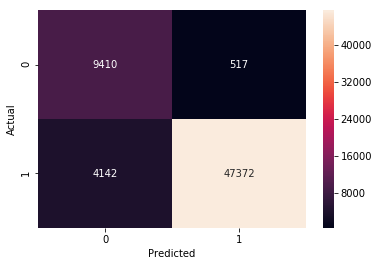

In [59]:
#report on training dataset
report(d_train_tf,y_train,model_temp_tf,auc_train_tf)

              precision    recall  f1-score   support

           0       0.66      0.89      0.75      4254
           1       0.98      0.91      0.94     22078

   micro avg       0.91      0.91      0.91     26332
   macro avg       0.82      0.90      0.85     26332
weighted avg       0.93      0.91      0.91     26332


The value of TPR is 0.911
The value of TNR is 0.887
The value of FPR is 0.113
The value of FNR is 0.089

The auc score is 0.962777


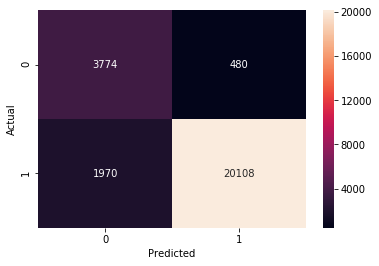

In [60]:
#report on test dataset
report(d_test_tf,y_test,model_temp_tf,auc_test_tf)

In [61]:
##sorting by weights (indices) and getting the last 10 weights
w_=model_temp_tf.coef_
feature_names = tf_idf_vect.get_feature_names()
pos = sorted(zip(w_[0], feature_names))
print("Top 10 Positive Words Are::\n",pos[-10:])

Top 10 Positive Words Are::
 [(3.305721741609117, 'excellent'), (3.320648542927482, 'wonderful'), (3.472128475735681, 'love'), (3.4913837734105817, 'loves'), (3.5110170065220347, 'nice'), (3.7436216801968, 'perfect'), (4.302247247942115, 'good'), (4.733289610714529, 'delicious'), (4.769759838586462, 'best'), (6.028308662357402, 'great')]


In [62]:
print("Top 10 Negative Words Are::\n",pos[:10])

Top 10 Negative Words Are::
 [(-4.5891499285610164, 'not'), (-4.541580009566832, 'disappointed'), (-3.519651250932601, 'not good'), (-3.4697351400159544, 'disappointing'), (-3.450467621606705, 'not worth'), (-3.3407626215701094, 'worst'), (-3.1637384417808283, 'terrible'), (-2.93789051147833, 'unfortunately'), (-2.898663850933937, 'awful'), (-2.7915288979057107, 'not recommend')]


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [63]:
# Please write all the code with proper documentation
#getting best alpha and best regularizer
alpha_grid_w2,reg_w2 = cv_sgd_grid(d_train_w2,y_train)

Time elapsed : 20.25 Seconds
 optimal alpha using Grid Search is {'alpha': 0.01, 'penalty': 'l2'}


In [64]:
#model with best regulariser
model_temp_w2=SGDClassifier(penalty=reg_w2,loss="hinge",alpha=alpha_grid_w2,class_weight='balanced')
model_temp_w2.fit(d_train_w2,y_train)

SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

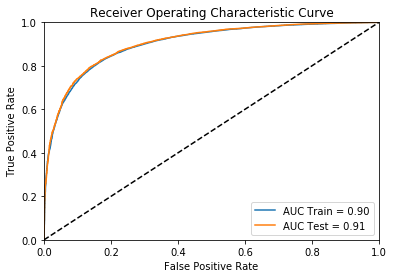

In [65]:
#plot roc curve for train and test data
#creating CalibrationModel on top of SGD
clf_w2=CalibratedClassifierCV(model_temp_w2,method='sigmoid',cv='prefit')
clf_w2.fit(d_train_w2,y_train)
auc_train_w2,auc_test_w2 = plotROC(d_train_w2,y_train,d_test_w2,y_test,clf_w2)

100%|██████████| 8/8 [00:06<00:00,  1.38it/s]


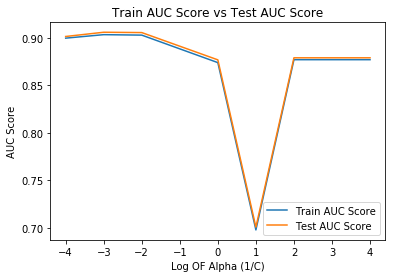

In [83]:
#plotting train vs test auc curve on log of alpha
plotTrainvsTestAUC(d_train_w2,y_train,d_test_w2,y_test,reg_w2)

              precision    recall  f1-score   support

           0       0.45      0.84      0.59      9927
           1       0.96      0.80      0.88     51514

   micro avg       0.81      0.81      0.81     61441
   macro avg       0.71      0.82      0.73     61441
weighted avg       0.88      0.81      0.83     61441


The value of TPR is 0.805
The value of TNR is 0.845
The value of FPR is 0.155
The value of FNR is 0.195

The auc score is 0.902817


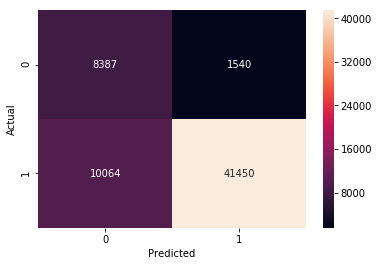

In [67]:
#report on training dataset
report(d_train_w2,y_train,model_temp_w2,auc_train_w2)

              precision    recall  f1-score   support

           0       0.45      0.85      0.59      4254
           1       0.97      0.80      0.88     22078

   micro avg       0.81      0.81      0.81     26332
   macro avg       0.71      0.83      0.73     26332
weighted avg       0.88      0.81      0.83     26332


The value of TPR is 0.800
The value of TNR is 0.854
The value of FPR is 0.146
The value of FNR is 0.200

The auc score is 0.905592


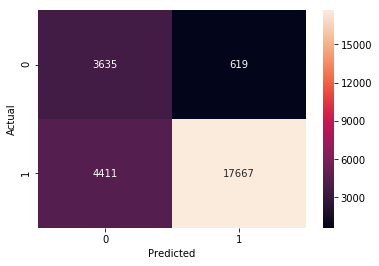

In [68]:
#report on test dataset
report(d_test_w2,y_test,model_temp_w2,auc_test_w2)

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [37]:
# Please write all the code with proper documentation
#getting best alpha and best regularizer
alpha_grid_tf_wt,reg_tf_wt = cv_sgd_grid(d_train_tf_wt,y_train)

Time elapsed : 35.14 Seconds
 optimal alpha using Grid Search is {'alpha': 0.01, 'penalty': 'l2'}


In [38]:
#model with best regulariser
model_temp_tf_wt=SGDClassifier(penalty=reg_tf_wt,loss="hinge",alpha=alpha_grid_tf_wt,class_weight='balanced')
model_temp_tf_wt.fit(d_train_tf_wt,y_train)

SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

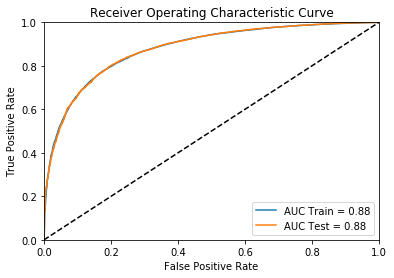

In [39]:
#plot roc curve for train and test data
#creating CalibrationModel on top of SGD
clf_av=CalibratedClassifierCV(model_temp_tf_wt,method='sigmoid',cv='prefit')
clf_av.fit(d_train_tf_wt,y_train)
auc_train_av,auc_test_av = plotROC(d_train_tf_wt,y_train,d_test_tf_wt,y_test,clf_av)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.42it/s]


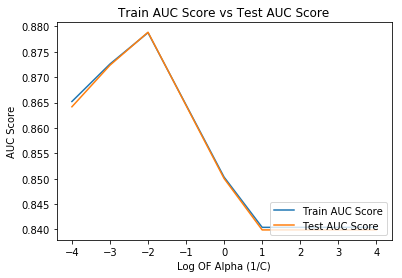

In [40]:
#plotting train vs test auc curve on log of alpha
plotTrainvsTestAUC(d_train_tf_wt,y_train,d_test_tf_wt,y_test,reg_tf_wt)

              precision    recall  f1-score   support

           0       0.42      0.82      0.55      9927
           1       0.96      0.78      0.86     51514

   micro avg       0.78      0.78      0.78     61441
   macro avg       0.69      0.80      0.70     61441
weighted avg       0.87      0.78      0.81     61441


The value of TPR is 0.776
The value of TNR is 0.825
The value of FPR is 0.175
The value of FNR is 0.224

The auc score is 0.878868


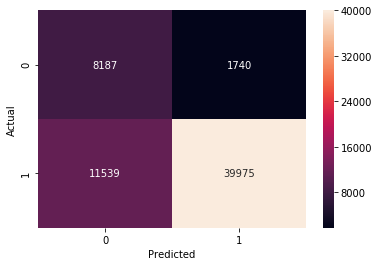

In [41]:
#report on training dataset
report(d_train_tf_wt,y_train,model_temp_tf_wt,auc_train_av)

              precision    recall  f1-score   support

           0       0.41      0.83      0.55      4254
           1       0.96      0.77      0.85     22078

   micro avg       0.78      0.78      0.78     26332
   macro avg       0.68      0.80      0.70     26332
weighted avg       0.87      0.78      0.81     26332


The value of TPR is 0.771
The value of TNR is 0.826
The value of FPR is 0.174
The value of FNR is 0.229

The auc score is 0.879016


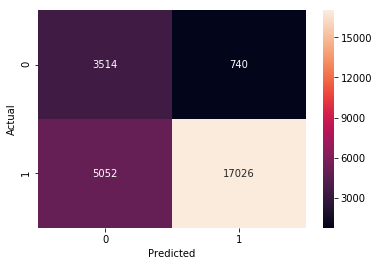

In [42]:
#report on test dataset
report(d_test_tf_wt,y_test,model_temp_tf_wt,auc_test_av)

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [75]:
#BoW with min_df=10,max_features=500
count_vect_rbf = CountVectorizer(dtype='float',min_df=10,max_features=500) #in scikit-learn
d_train_rbf =count_vect_rbf.fit_transform(dw_train)
print("the type of count vectorizer ",type(d_train_rbf))
print("the shape of train-text BOW vectorizer ",d_train_rbf.get_shape())

d_test_rbf = count_vect_rbf.transform(dw_test)
print("the shape of test-text BOW vectorizer ",d_test_rbf.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train-text BOW vectorizer  (61441, 500)
the shape of test-text BOW vectorizer  (26332, 500)


In [43]:
# Please write all the code with proper documentation
def cv_svc_grid(d_train, y_train):
    import warnings
    warnings.filterwarnings('ignore')

    #defining 'C' for grid-search
    param= {'C':[0.0001,0.001,0.01,1,10,100,1000,10000]}

    #Using Grid Search to get Best alpha=1/c
    start = time()
    #hinge loss for svm
    clfSVC = SVC( kernel='rbf', class_weight='balanced')
    clf = GridSearchCV(clfSVC, param, cv=5,scoring='roc_auc')
    clf.fit(d_train, y_train)
    print("Time elapsed : %.2f Seconds" % (time() - start))
    print(" optimal alpha using Grid Search is " + str(clf.best_params_))
    optimal_c_grid=clf.best_params_.get('C')
    return optimal_c_grid

In [44]:
def plotTrainvsTestAUC_rbf(d_trai,y_trai,d_tes,y_tes):
    import warnings
    from math import log
    warnings.filterwarnings('ignore')
    auc_train_list=list()
    auc_test_list=list()
    param=[0.0001,0.001,0.01,1,10,100,1000,10000]
    x=list()
    for i in tqdm(param):
        x.append(log(i,10))
        model=SVC( kernel='rbf', C=i,class_weight='balanced',probability=True)
        model.fit(d_trai,y_trai)
        train_score = model.predict_proba(d_trai)[:,1]
        test_score = model.predict_proba(d_tes)[:,1]
        fpr_train, tpr_train, _ = roc_curve(y_trai, train_score)
        fpr_test, tpr_test, _ = roc_curve(y_tes, test_score)
        auc_train_list.append(auc(fpr_train, tpr_train))
        auc_test_list.append(auc(fpr_test, tpr_test))
    plt.title('Train AUC Score vs Test AUC Score')
    plt.plot(x, auc_train_list, label = 'Train AUC Score')
    plt.plot(x, auc_test_list, label = 'Test AUC Score')
    plt.legend(loc = 'lower right')
    plt.xlabel('Log OF C')
    plt.ylabel('AUC Score')
    plt.show()

In [85]:
#getting best value for C
d_train_rbf_10000=d_train_rbf[:10000]
y_train_10000=y_train[:10000]
c_grid_rbf = cv_svc_grid(d_train_rbf_10000,y_train_10000)

Time elapsed : 753.45 Seconds
 optimal alpha using Grid Search is {'C': 10}


In [86]:
#model with kernal = 'rbf'
svc_bow= SVC( kernel='rbf', C= c_grid_rbf, class_weight='balanced',probability = True)
svc_bow.fit(d_train_rbf_10000,y_train_10000)

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

100%|██████████| 8/8 [15:44<00:00, 100.90s/it]


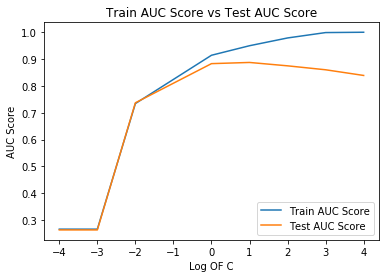

In [87]:
#train auc vs test auc curve on log of C
plotTrainvsTestAUC_rbf(d_train_rbf_10000,y_train_10000,d_test_rbf,y_test)

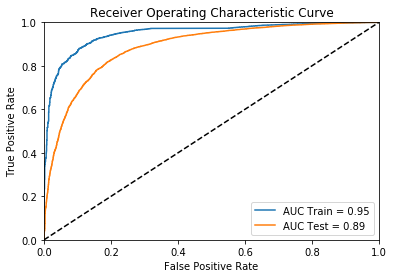

In [88]:
#plot roc curve for train and test data
auc_train_sb,auc_test_sb = plotROC(d_train_rbf_10000,y_train_10000,d_test_rbf,y_test,svc_bow)

              precision    recall  f1-score   support

           0       0.54      0.91      0.68      1610
           1       0.98      0.85      0.91      8390

   micro avg       0.86      0.86      0.86     10000
   macro avg       0.76      0.88      0.79     10000
weighted avg       0.91      0.86      0.87     10000


The value of TPR is 0.851
The value of TNR is 0.912
The value of FPR is 0.088
The value of FNR is 0.149

The auc score is 0.949659


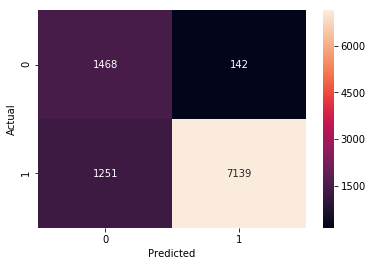

In [89]:
#report on training dataset
report(d_train_rbf_10000,y_train_10000,svc_bow,auc_train_sb)

              precision    recall  f1-score   support

           0       0.47      0.80      0.59      4254
           1       0.95      0.83      0.89     22078

   micro avg       0.82      0.82      0.82     26332
   macro avg       0.71      0.81      0.74     26332
weighted avg       0.88      0.82      0.84     26332


The value of TPR is 0.830
The value of TNR is 0.796
The value of FPR is 0.204
The value of FNR is 0.170

The auc score is 0.887368


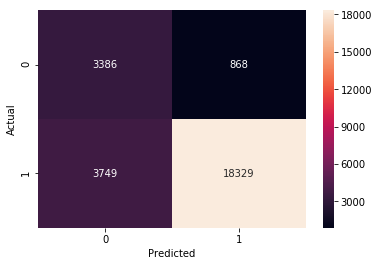

In [90]:
#report on test dataset
report(d_test_rbf,y_test,svc_bow,auc_test_sb)

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [91]:
# Please write all the code with proper documentation
tf_idf_vect_rbf = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
d_train_tf_rbf =tf_idf_vect_rbf.fit_transform(dw_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)
#Vectorize cv and test data
print("the type of count vectorizer ",type(d_train_tf))
print("the shape of train-text BOW vectorizer ",d_train_tf_rbf.get_shape())

d_test_tf_rbf = tf_idf_vect_rbf.transform(dw_test)
print("the shape of test-text BOW vectorizer ",d_test_tf_rbf.get_shape())

some sample features(unique words in the corpus) ['aafco', 'aback', 'abandon', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew', 'able drink']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train-text BOW vectorizer  (61441, 500)
the shape of test-text BOW vectorizer  (26332, 500)


In [92]:
#getting best value for C
d_train_tf_rbf_10000=d_train_tf_rbf[:10000]
c_grid_rbf_tf = cv_svc_grid(d_train_tf_rbf_10000,y_train_10000)

Time elapsed : 901.33 Seconds
 optimal alpha using Grid Search is {'C': 100}


In [93]:
#model with kernal = 'rbf'
svc_tf = SVC( kernel='rbf', C= c_grid_rbf_tf, class_weight='balanced',probability = True)
svc_tf.fit(d_train_tf_rbf_10000,y_train_10000)

SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

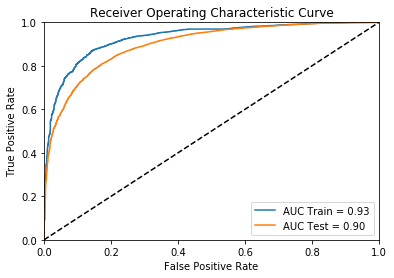

In [94]:
#plot roc curve for train and test data 
auc_train_st,auc_test_st = plotROC(d_train_tf_rbf_10000,y_train_10000,d_test_tf_rbf,y_test,svc_tf)

100%|██████████| 8/8 [18:42<00:00, 120.21s/it]


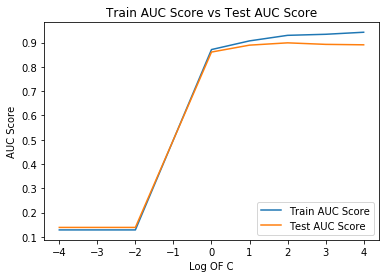

In [95]:
#train auc vs test auc curve on log of C
plotTrainvsTestAUC_rbf(d_train_tf_rbf_10000,y_train_10000,d_test_tf_rbf,y_test)

              precision    recall  f1-score   support

           0       0.50      0.88      0.64      1610
           1       0.97      0.83      0.90      8390

   micro avg       0.84      0.84      0.84     10000
   macro avg       0.74      0.86      0.77     10000
weighted avg       0.90      0.84      0.86     10000


The value of TPR is 0.831
The value of TNR is 0.884
The value of FPR is 0.116
The value of FNR is 0.169

The auc score is 0.929887


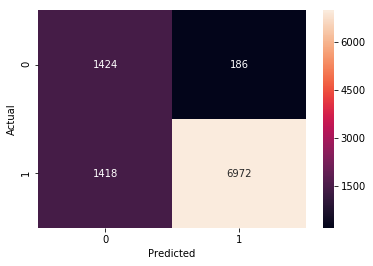

In [96]:
#report on training dataset
report(d_train_tf_rbf_10000,y_train_10000,svc_tf,auc_train_st)

              precision    recall  f1-score   support

           0       0.46      0.81      0.59      4254
           1       0.96      0.82      0.88     22078

   micro avg       0.82      0.82      0.82     26332
   macro avg       0.71      0.82      0.74     26332
weighted avg       0.88      0.82      0.84     26332


The value of TPR is 0.819
The value of TNR is 0.814
The value of FPR is 0.186
The value of FNR is 0.181

The auc score is 0.898992


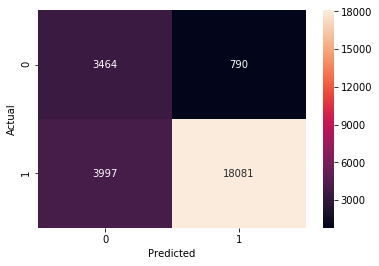

In [97]:
#report on test dataset
report(d_test_tf_rbf,y_test,svc_tf,auc_test_st)

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [98]:
#getting best value for C
d_train_w2_10000=d_train_w2[:10000]
c_grid_rbf_w2 = cv_svc_grid(d_train_w2_10000,y_train_10000)

Time elapsed : 489.23 Seconds
 optimal alpha using Grid Search is {'C': 10}


In [99]:
#model with kernal = 'rbf'
svc_w2=SVC(kernel='rbf',C=c_grid_rbf_w2,class_weight='balanced',probability=True)
svc_w2.fit(d_train_w2_10000,y_train_10000)

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

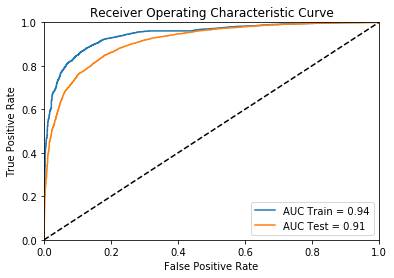

In [100]:
#plot roc curve for train and test data
auc_train_sav,auc_test_sav = plotROC(d_train_w2_10000,y_train_10000,d_test_w2,y_test,svc_w2)

100%|██████████| 8/8 [11:22<00:00, 103.16s/it]


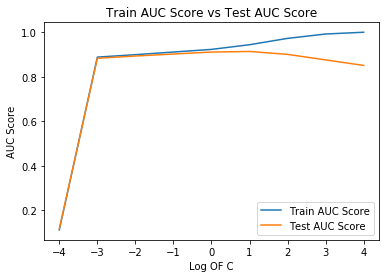

In [101]:
#train auc vs test auc curve
plotTrainvsTestAUC_rbf(d_train_w2_10000,y_train_10000,d_test_w2,y_test)

              precision    recall  f1-score   support

           0       0.53      0.90      0.67      1610
           1       0.98      0.85      0.91      8390

   micro avg       0.85      0.85      0.85     10000
   macro avg       0.75      0.88      0.79     10000
weighted avg       0.91      0.85      0.87     10000


The value of TPR is 0.845
The value of TNR is 0.905
The value of FPR is 0.095
The value of FNR is 0.155

The auc score is 0.943407


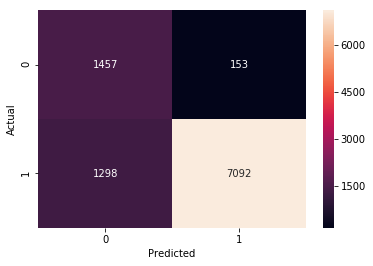

In [102]:
#report on training dataset
report(d_train_w2_10000,y_train_10000,svc_w2,auc_train_sav)

              precision    recall  f1-score   support

           0       0.49      0.83      0.61      4254
           1       0.96      0.83      0.89     22078

   micro avg       0.83      0.83      0.83     26332
   macro avg       0.72      0.83      0.75     26332
weighted avg       0.89      0.83      0.85     26332


The value of TPR is 0.830
The value of TNR is 0.834
The value of FPR is 0.166
The value of FNR is 0.170

The auc score is 0.913134


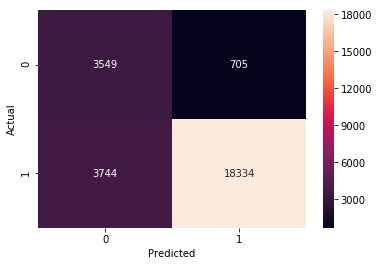

In [103]:
#report on test dataset
report(d_test_w2,y_test,svc_w2,auc_test_sav)

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [47]:
#getting best value for C
d_train_tf_wt_10000=d_train_tf_wt[:10000]
y_train_10000=y_train[:10000]
c_grid_rbf_av = cv_svc_grid(d_train_tf_wt_10000,y_train_10000)

Time elapsed : 789.29 Seconds
 optimal alpha using Grid Search is {'C': 10}


In [48]:
#model with kernal = 'rbf'
svc_av=SVC(kernel='rbf',C=c_grid_rbf_av,class_weight='balanced',probability=True)
svc_av.fit(d_train_tf_wt_10000,y_train_10000)

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

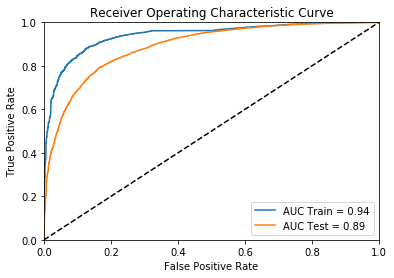

In [49]:
#plot roc curve for train and test data
auc_train_stf,auc_test_stf = plotROC(d_train_tf_wt_10000,y_train_10000,d_test_tf_wt,y_test,svc_av)

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [18:51<00:00, 168.60s/it]


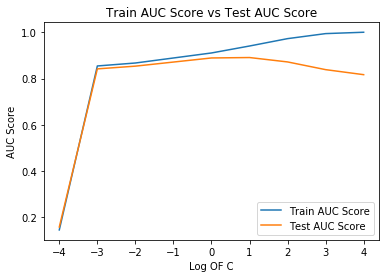

In [50]:
#train auc vs test auc curve
plotTrainvsTestAUC_rbf(d_train_tf_wt_10000,y_train_10000,d_test_tf_wt,y_test)

              precision    recall  f1-score   support

           0       0.52      0.90      0.66      1610
           1       0.98      0.84      0.91      8390

   micro avg       0.85      0.85      0.85     10000
   macro avg       0.75      0.87      0.78     10000
weighted avg       0.91      0.85      0.87     10000


The value of TPR is 0.842
The value of TNR is 0.903
The value of FPR is 0.097
The value of FNR is 0.158

The auc score is 0.940430


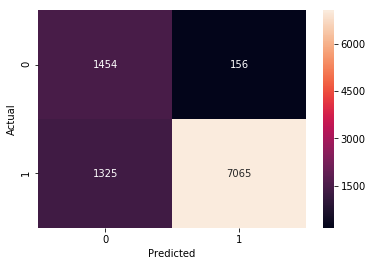

In [51]:
#report on training dataset
report(d_train_tf_wt_10000,y_train_10000,svc_av,auc_train_stf)

              precision    recall  f1-score   support

           0       0.46      0.80      0.59      4254
           1       0.95      0.82      0.88     22078

   micro avg       0.82      0.82      0.82     26332
   macro avg       0.71      0.81      0.73     26332
weighted avg       0.88      0.82      0.83     26332


The value of TPR is 0.821
The value of TNR is 0.798
The value of FPR is 0.202
The value of FNR is 0.179

The auc score is 0.890597


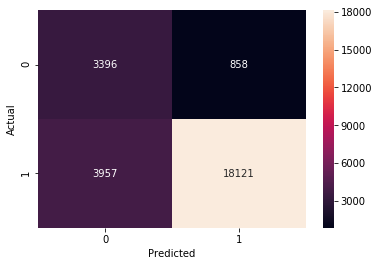

In [52]:
#report on test dataset
report(d_test_tf_wt,y_test,svc_av,auc_test_stf)

## Adding Review Summary To the Reviews And Length Of Reviews

In [75]:
listA = [preprocessed_summary[i] +" " + preprocessed_reviews[i] for i in range(len(preprocessed_reviews))]
dwA_train,dwA_test,y_train,y_test=ms.train_test_split(listA, y, stratify=y, test_size=0.3, random_state=0)

In [76]:
trainA_list=[]
for sent in dwA_train:
    trainA_list.append(sent.split())
w2vA_model=Word2Vec(trainA_list,min_count=5,size=50, workers=4)
print(w2vA_model.wv.most_similar('great'))
print('='*50)
print(w2vA_model.wv.most_similar('worst'))
w2vA_words = list(w2vA_model.wv.vocab)

[('excellent', 0.8297293782234192), ('fantastic', 0.8061206340789795), ('awesome', 0.792291522026062), ('terrific', 0.7863889932632446), ('good', 0.7747745513916016), ('wonderful', 0.7552236318588257), ('perfect', 0.7239371538162231), ('amazing', 0.6951207518577576), ('nice', 0.6296993494033813), ('fabulous', 0.6207087635993958)]
[('greatest', 0.716107964515686), ('best', 0.7120872139930725), ('nastiest', 0.6321882605552673), ('experienced', 0.6300017833709717), ('ive', 0.6201525926589966), ('smoothest', 0.6071344017982483), ('disgusting', 0.5972799062728882), ('awful', 0.591404139995575), ('horrible', 0.5855566263198853), ('closest', 0.5741324424743652)]


In [77]:
# average Word2Vec
# compute average word2vec for each review in train dataset.
#train dataset
d_trainA_w2 = [];
for sent in tqdm(trainA_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2vA_words:
            vec = w2vA_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        else:
            sent_vec+=0
    if cnt_words != 0:
        sent_vec /= cnt_words
    d_trainA_w2.append(sent_vec)
print(len(d_trainA_w2))
print(len(d_trainA_w2[0]))

100%|████████████████████████████████████████████████████████████████████████████| 61441/61441 [15:54<00:00, 64.37it/s]


61441
50


In [78]:
# average Word2Vec
# compute average word2vec for each review in train dataset.
#test dataset
testA_list=[]
for sent in dwA_test:
    testA_list.append(sent.split())
d_testA_w2 = [];
for sent in tqdm(testA_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2vA_words:
            vec = w2vA_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        else:
            sent_vec+=0
    if cnt_words != 0:
        sent_vec /= cnt_words
    d_testA_w2.append(sent_vec)
print(len(d_testA_w2))
print(len(d_testA_w2[0]))

100%|████████████████████████████████████████████████████████████████████████████| 26332/26332 [05:58<00:00, 63.34it/s]


26332
50


In [79]:
#adding length of reviews
train_ex = [np.append(d_trainA_w2[i],len(dwA_train[i])) for i in range(len(dwA_train))]
test_ex = [np.append(d_testA_w2[i],len(dwA_test[i])) for i in range(len(dwA_test))]

In [80]:
#getting best alpha and best regularizer
alpha_grid_ex,reg_ex = cv_sgd_grid(train_ex,y_train)

Time elapsed : 100.91 Seconds
 optimal alpha using Grid Search is {'alpha': 0.0001, 'penalty': 'l1'}


In [81]:
#model with best regulariser
model_temp_ex=SGDClassifier(penalty=reg_ex,loss="hinge",alpha=alpha_grid_ex,class_weight='balanced')
model_temp_ex.fit(train_ex,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

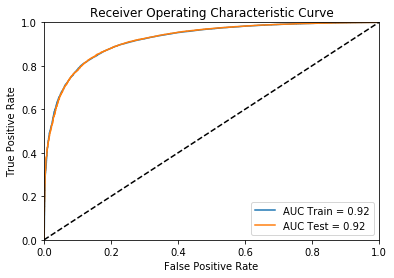

In [82]:
#plot roc curve on train and test data
#creating CalibrationModel on top of SGD
clf_ex=CalibratedClassifierCV(model_temp_ex,method='sigmoid',cv='prefit')
clf_ex.fit(train_ex,y_train)
auc_train_ex,auc_test_ex=plotROC(train_ex,y_train,test_ex,y_test,clf_ex)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.45s/it]


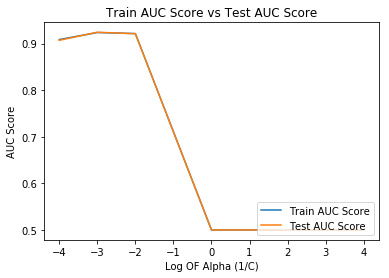

In [83]:
#plotting train vs test auc curve on log of alpha
plotTrainvsTestAUC(train_ex,y_train,test_ex,y_test,reg_ex)

              precision    recall  f1-score   support

           0       0.59      0.78      0.67      9927
           1       0.95      0.89      0.92     51514

   micro avg       0.88      0.88      0.88     61441
   macro avg       0.77      0.84      0.80     61441
weighted avg       0.90      0.88      0.88     61441


The value of TPR is 0.894
The value of TNR is 0.778
The value of FPR is 0.222
The value of FNR is 0.106

The auc score is 0.922438


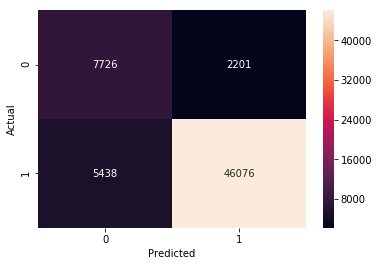

In [84]:
#report on training dataset
report(train_ex,y_train,model_temp_ex,auc_train_ex)

              precision    recall  f1-score   support

           0       0.59      0.78      0.67      4254
           1       0.95      0.89      0.92     22078

   micro avg       0.88      0.88      0.88     26332
   macro avg       0.77      0.84      0.80     26332
weighted avg       0.90      0.88      0.88     26332


The value of TPR is 0.895
The value of TNR is 0.778
The value of FPR is 0.222
The value of FNR is 0.105

The auc score is 0.922786


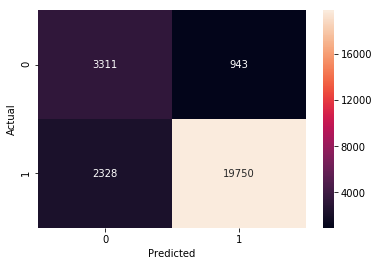

In [85]:
#report on training dataset
report(test_ex,y_test,model_temp_ex,auc_test_ex)

## Adding Length Of Reviews As A Feature

In [62]:
#adding length of reviews
train_ex1 = [np.append(d_train_w2[i],len(dw_train[i])) for i in range(len(dw_train))]
test_ex1 = [np.append(d_test_w2[i],len(dw_test[i])) for i in range(len(dw_test))]

In [71]:
#getting best alpha and best regularizer
alpha_grid_ex1,reg_ex1 = cv_sgd_grid(train_ex1,y_train)

Time elapsed : 83.92 Seconds
 optimal alpha using Grid Search is {'alpha': 0.001, 'penalty': 'l1'}


In [72]:
#model with best regulariser
model_temp_ex1=SGDClassifier(penalty=reg_ex1,loss="hinge",alpha=alpha_grid_ex1,class_weight='balanced')
model_temp_ex1.fit(train_ex1,y_train)

SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

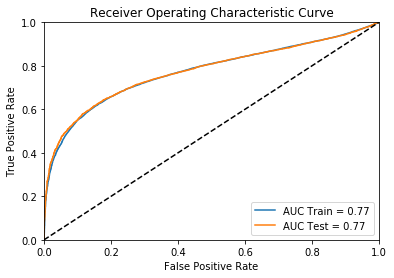

In [73]:
#plot roc curve on train and test data
#creating CalibrationModel on top of SGD
clf_ex1=CalibratedClassifierCV(model_temp_ex1,method='sigmoid',cv='prefit')
clf_ex1.fit(train_ex1,y_train)
auc_train_ex1,auc_test_ex1=plotROC(train_ex1,y_train,test_ex1,y_test,clf_ex1)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.50s/it]


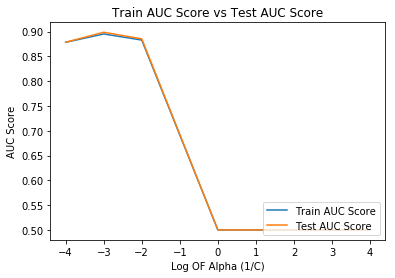

In [86]:
#plotting train vs test auc curve on log of alpha
plotTrainvsTestAUC(train_ex1,y_train,test_ex1,y_test,reg_ex1)

              precision    recall  f1-score   support

           0       0.24      0.95      0.39      9927
           1       0.98      0.43      0.60     51514

   micro avg       0.51      0.51      0.51     61441
   macro avg       0.61      0.69      0.49     61441
weighted avg       0.86      0.51      0.56     61441


The value of TPR is 0.427
The value of TNR is 0.955
The value of FPR is 0.045
The value of FNR is 0.573

The auc score is 0.772975


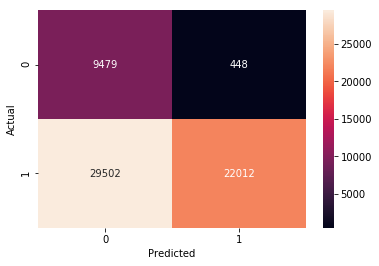

In [87]:
#report on training dataset
report(train_ex1,y_train,model_temp_ex1,auc_train_ex1)

              precision    recall  f1-score   support

           0       0.24      0.96      0.39      4254
           1       0.98      0.42      0.59     22078

   micro avg       0.51      0.51      0.51     26332
   macro avg       0.61      0.69      0.49     26332
weighted avg       0.86      0.51      0.56     26332


The value of TPR is 0.421
The value of TNR is 0.963
The value of FPR is 0.037
The value of FNR is 0.579

The auc score is 0.774824


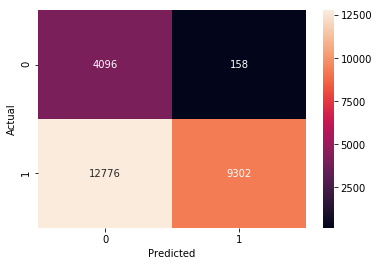

In [88]:
#report on training dataset
report(test_ex1,y_test,model_temp_ex1,auc_test_ex1)

## Training Model on Review Summary as a Feature

In [96]:
#getting best alpha and best regularizer
alpha_grid_ex2,reg_ex2 = cv_sgd_grid(d_trainA_w2,y_train)

Time elapsed : 90.67 Seconds
 optimal alpha using Grid Search is {'alpha': 0.01, 'penalty': 'l2'}


In [97]:
#model with best regulariser
model_temp_ex2=SGDClassifier(penalty=reg_ex2,loss="hinge",alpha=alpha_grid_ex2,class_weight='balanced')
model_temp_ex2.fit(d_trainA_w2,y_train)

SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

100%|███████████████████████████████████████████████| 8/8 [00:19<00:00,  2.58s/it]


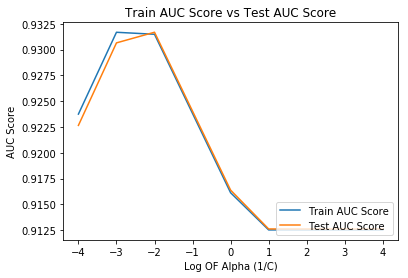

In [98]:
#plotting train vs test auc curve on log of alpha
plotTrainvsTestAUC(d_trainA_w2,y_train,d_testA_w2,y_test,reg_ex2)

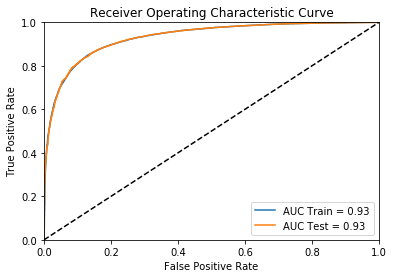

In [102]:
#plot roc curve on train and test data
#creating CalibrationModel on top of SGD
clf_ex2=CalibratedClassifierCV(model_temp_ex2,method='sigmoid',cv='prefit')
clf_ex2.fit(d_trainA_w2,y_train)
auc_train_ex2,auc_test_ex2=plotROC(d_trainA_w2,y_train,d_testA_w2,y_test,clf_ex2)

              precision    recall  f1-score   support

           0       0.49      0.89      0.64      9927
           1       0.97      0.82      0.89     51514

   micro avg       0.83      0.83      0.83     61441
   macro avg       0.73      0.86      0.76     61441
weighted avg       0.90      0.83      0.85     61441


The value of TPR is 0.824
The value of TNR is 0.889
The value of FPR is 0.111
The value of FNR is 0.176

The auc score is 0.931287


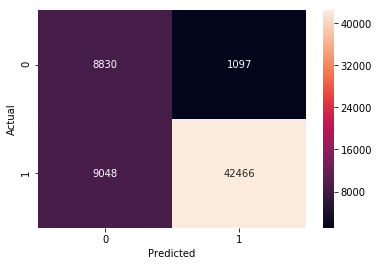

In [103]:
#report on training dataset
report(d_trainA_w2,y_train,model_temp_ex2,auc_train_ex2)

              precision    recall  f1-score   support

           0       0.49      0.89      0.63      4254
           1       0.98      0.82      0.89     22078

   micro avg       0.83      0.83      0.83     26332
   macro avg       0.73      0.86      0.76     26332
weighted avg       0.90      0.83      0.85     26332


The value of TPR is 0.819
The value of TNR is 0.894
The value of FPR is 0.106
The value of FNR is 0.181

The auc score is 0.931552


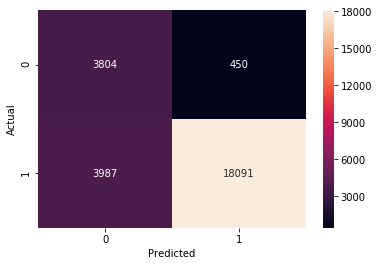

In [104]:
#report on training dataset
report(d_testA_w2,y_test,model_temp_ex2,auc_test_ex2)

# [6] Conclusions

In [54]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
    
pt = PrettyTable()

pt.field_names = ["Kernal","Vectorising Method"," Best Regularizer", "Optimal C", "AUC Score","Precision", "Recall", "F1-Score"]

pt.add_row(["Linear","Bag Of Words","L2", 1000, 0.93, 0.91, 0.90, 0.91 ])
pt.add_row(["","Tf-Idf","L2", 10000, 0.96, 0.93, 0.91, 0.91 ])
pt.add_row(["","AV-W2V","L2", 100, 0.905, 0.88, 0.81, 0.83 ])
pt.add_row(["","TfIdf-W2V","L2", 100, 0.88, 0.87, 0.78, 0.81 ])
pt.add_row(["","","","","","","",""])
pt.add_row(["RBF","Bag Of Words","-", 10, 0.89, 0.88, 0.82, 0.84 ])
pt.add_row(["","Tf-Idf","-", 100, 0.90, 0.88, 0.82, 0.84 ])
pt.add_row(["","AV-W2V","-", 10, 0.91, 0.89, 0.83, 0.85 ])
pt.add_row(["","TfIdf-W2V","-", 10, 0.89, 0.88, 0.82, 0.83 ])
pt.add_row(["","","","","","","",""])
pt.add_row(["Linear","Rev+LenRev with AV-W2V","L1", 1000, 0.77, 0.86, 0.51, 0.56 ])
pt.add_row(["Linear","Rev+Des+LenRev with AV-W2V","L1", 10000, 0.92, 0.90, 0.88, 0.88 ])
pt.add_row(["Linear","Rev+Des with AV-W2V","L2", 100, 0.93, 0.90, 0.80, 0.85 ])


print(pt)
print("\n\n Note: Auc Score, Precision, Recall and F1- Score are on Test Data")

+--------+----------------------------+-------------------+-----------+-----------+-----------+--------+----------+
| Kernal |     Vectorising Method     |  Best Regularizer | Optimal C | AUC Score | Precision | Recall | F1-Score |
+--------+----------------------------+-------------------+-----------+-----------+-----------+--------+----------+
| Linear |        Bag Of Words        |         L2        |    1000   |    0.93   |    0.91   |  0.9   |   0.91   |
|        |           Tf-Idf           |         L2        |   10000   |    0.96   |    0.93   |  0.91  |   0.91   |
|        |           AV-W2V           |         L2        |    100    |   0.905   |    0.88   |  0.81  |   0.83   |
|        |         TfIdf-W2V          |         L2        |    100    |    0.88   |    0.87   |  0.78  |   0.81   |
|        |                            |                   |           |           |           |        |          |
|  RBF   |        Bag Of Words        |         -         |     10    | 

1) The highest AUC score is achieved after vectorization of reviews using *TF-IDF* method with *L2* (after getting L2 as best regulariser). The AUC score is 0.96.

2) *Linear Kernal* is clearly a better kernal than *RBF Kernal* when vectorization of reviews is done using *Bag Of Words* and *TF-IDF*.

3) *RBF Kernal* is better in case of *Average Word2Vec* and *TF-IDF weighted Word2Vec* but with a very close margin.

4) The best value of C, the hyperparameter, remains same from grid search and from Train vs Test AUC score plot on C.

5) Most of the words are common in top 10 neagtive words using Bag of Words and Tf-Idf.

6) Most of the words are common in top 10 Positive words using Bag of Words and Tf-Idf.

7) The lowest ROC-AUC score is achieved after vectorization by *Tf-Idf weighted Word2Vec* and when *Linear Kernal* is used. The score is 0.88.

8) We can say that model is very good in predicting positive reviews looking at the Precision, Recall and F1-score.

9) The model performed terribly after adding only length of reviews as a feature. So polarity of reviews is not dependent on length of reviews.

10) The AUC score for Average W2V featurization has improved after adding summary and length of reviews as features by 1.8%.

11) The AUC score for Average W2V featurization increased by 2.8% after adding the summary as a feature. This also implies  that polarity of reviews is not dependent on length of reviews since, there is a decrease in performance by 1% when length has been added as a feature alongwith summary.